# Heart disease Kaggle dataset

Dado un dataset inicial con datos de pacientes, se pretende predecir si tendrán una enfermedad de corazón o no. La información ha sido recogida de un dataset de Kaggle ``https://www.kaggle.com/ronitf/heart-disease-uci``

Si accedemos a la información del dataset proporcionado en la descipción del enlace anterior, vemos que tiene 13 columnas, cada el siguiente significado:

1. age 
2. sex 
3. chest pain type (4 values) 
4. resting blood pressure 
5. serum cholestoral in mg/dl 
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved 
9. exercise induced angina 
10. oldpeak = ST depression induced by exercise relative to rest 
11. the slope of the peak exercise ST segment 
12. number of major vessels (0-3) colored by flourosopy 
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. target



In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/antoniomfc/HeartDiseasePrediction/main/heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


No es necesario hacer ninguna transformación, ya que como veremos, no hay valores nulos y todos los datos son de tipo numéricos

### Exploración de los datos

In [4]:
# Comprobamos si hay nulos y el tipo de las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


No hay nulos y tampoco se requiere ninguna converasión de tipo

In [5]:
df.shape

(303, 14)

####Exploración de los datos categóricos del dataset

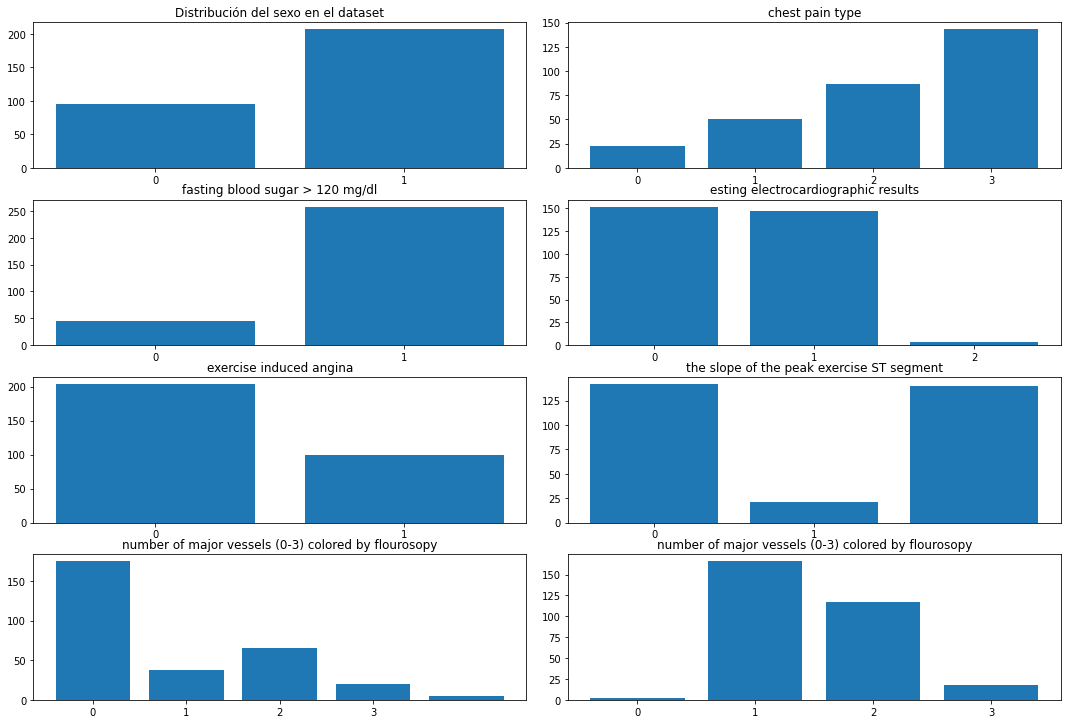

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10))

fig.tight_layout()

ax[0, 0].bar(df.sex.unique(), df.sex.value_counts())
ax[0, 0].set_xticks([0, 1])
ax[0, 0].set_title("Distribución del sexo en el dataset")

ax[0, 1].bar(df.cp.unique(), df.cp.value_counts())
ax[0, 1].set_title("chest pain type")
ax[0, 1].set_xticks([0, 1, 2, 3])

ax[1, 0].bar(df.fbs.unique(), df.fbs.value_counts())
ax[1, 0].set_xticks([0, 1])
ax[1, 0].set_title("fasting blood sugar > 120 mg/dl")

ax[1, 1].bar(df.restecg.unique(), df.restecg.value_counts())
ax[1, 1].set_title("esting electrocardiographic results")
ax[1, 1].set_xticks([0, 1, 2])

ax[2, 0].bar(df.exang.unique(), df.exang.value_counts())
ax[2, 0].set_xticks([0, 1])
ax[2, 0].set_title("exercise induced angina")

# slope	ca	thal	target
ax[2, 1].bar(df.slope.unique(), df.slope.value_counts())
ax[2, 1].set_xticks([0, 1])
ax[2, 1].set_title("the slope of the peak exercise ST segment")

ax[3, 0].bar(df.ca.unique(), df.ca.value_counts())
ax[3, 0].set_xticks([0, 1, 2, 3])
ax[3, 0].set_title("number of major vessels (0-3) colored by flourosopy")


ax[3, 1].bar(df.thal.unique(), df.thal.value_counts())
ax[3, 1].set_xticks([0, 1, 2, 3])
ax[3, 1].set_title("number of major vessels (0-3) colored by flourosopy")
plt.show()

Como podemos observar, algunos de los atributos como el sexo o restecg no están balanceados.

In [14]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


#### Exploración de datos cuantitativos

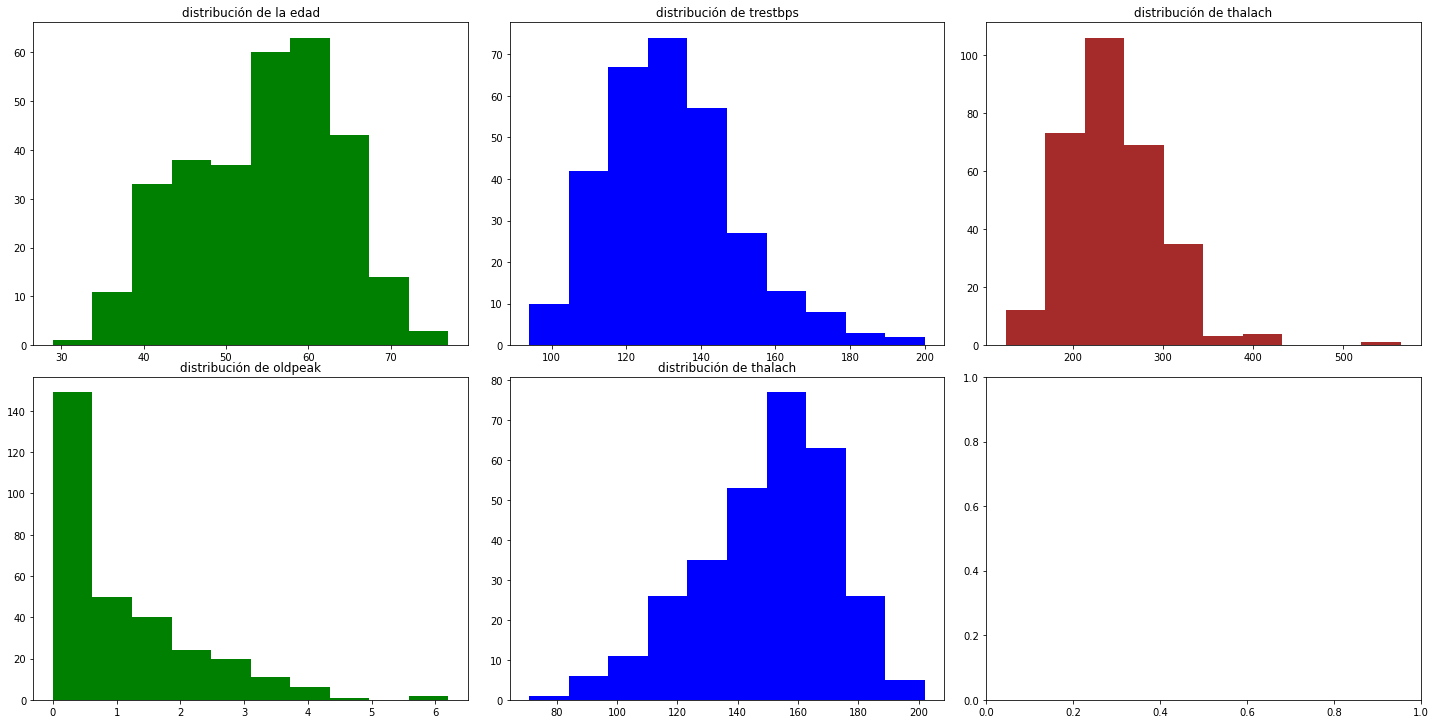

In [32]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

fig.tight_layout()
ax[0, 0].hist(df.age, color="green")
ax[0, 0].set_title("distribución de la edad")

ax[0, 1].hist(df.trestbps, color="blue")
ax[0, 1].set_title("distribución de trestbps")

ax[0, 2].hist(df.chol, color="brown")
ax[0, 2].set_title("distribución de thalach")

ax[1, 0].hist(df.oldpeak, color="green")
ax[1, 0].set_title("distribución de oldpeak")

ax[1, 1].hist(df.thalach, color="blue")
ax[1, 1].set_title("distribución de thalach")

plt.show()

Una vez visto como se distribuyen los datos, vamos a ver la columna target si está balanceada y cuáles son sus posibles valores.

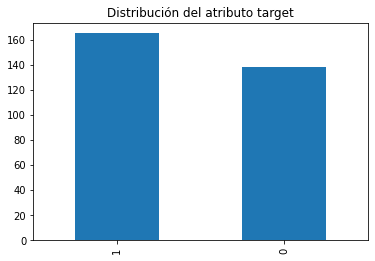

In [41]:

df.target.value_counts().plot(kind='bar')
plt.xticks([0, 1])
plt.title("Distribución del atributo target")
plt.show()

### Escalado de los datos con MinMaxScaler




In [53]:
# Dividimos los datos entre los atributos y el target de nuestro dataset
X = df.drop("target", axis=1).copy()
y = df['target']

In [54]:
# Escalamos los datos con MinMaxScaler, lo que dara un rango entre 0 y 1 para cada columna
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [59]:
# Podemos ver que ahora los datos están entre 0 y 1
X

array([[0.70833333, 1.        , 1.        , ..., 0.        , 0.        ,
        0.33333333],
       [0.16666667, 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.66666667],
       [0.25      , 0.        , 0.33333333, ..., 1.        , 0.        ,
        0.66666667],
       ...,
       [0.8125    , 1.        , 0.        , ..., 0.5       , 0.5       ,
        1.        ],
       [0.58333333, 1.        , 0.        , ..., 0.5       , 0.25      ,
        1.        ],
       [0.58333333, 0.        , 0.33333333, ..., 0.5       , 0.25      ,
        0.66666667]])

Como podemos observar, la columna target está más o menos balanceada.

### Entrenamiento

In [65]:
# Dividimos los datos entre un 80% para entrenamiento y 20% para validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 13), (61, 13), (242,), (61,))

In [66]:
# Uso de GridSearchCV para encontrar los mejores hiperparámetros del modelo que queremos obtener

# Random seed a 42 para poder simular con los mismos resultados
np.random.seed = 42

rf_dict = {
  "n_estimators": [50, 100, 150, 200, 250, 300],
  "criterion": ["gini", "entropy"]    
}

model = GridSearchCV(RandomForestClassifier(), rf_dict)
model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

###Evaluación del modelo

Aquí veremos la precisión del modelo, la matriz de confusión para visualizar los TP TN FP FN, la curva roc y el reporte de clasificación.

In [70]:
print(f"La precisión del modelo es de {round(model.score(X_test, y_test), 2) * 100}%")

La precisión del modelo es de 82.0%


#####Matriz de confusión


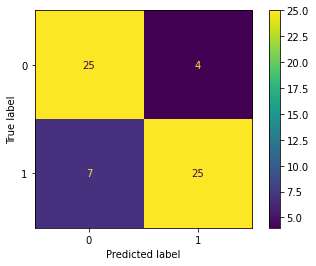

In [71]:
plot_confusion_matrix(model, X_test, y_test);

Por último, vemos el reporte de clasificación

In [72]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        29
           1       0.86      0.78      0.82        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

